# Predict Solar Array Performance

## Obtain and Visualize Meterological Data

Data were downloaded from "USA Continental & Mexico - (5, 30, 60min / 2km / 2019-2022)" dataset via https://nsrdb.nrel.gov/data-viewer for years 2018 to 2022

Let's get started by importing the data



In [27]:
import pandas as pd

# These data files are all shared (viewable) in Google Drive
# Create a dictionary to store all of the unique FILE_IDs for Google Drive
data_file_ids = {}
data_file_ids[2022] = '1ZATFflB62KstcAAf66m6k-BNnw3vpm7U'
data_file_ids[2021] = '1GgbtcyCQy3OxNbX2WYFZhObYVVk5RA4F'
data_file_ids[2020] = '1EmAh-z59w0sl5yPLoogWuUHyzQGbvBx6'
data_file_ids[2019] = '1QdglH5gN6oPnXuUzCTG8UcTnWf_elFbX'
data_file_ids[2018] = '1XaAEfYpqFlU79YVYPboaFiJjq1lQXrah'

def download_data_file(file_id,type='met'):
    """
    Download data file from Google Drive
    """
    url = 'https://drive.google.com/uc?export=download&id='+file_id
    if type == 'met':
        return pd.read_csv(url, header=2)
    elif type == 'solar':
        temp = pd.read_csv(url)
        temp.set_index('date', inplace=True)
        temp.index = pd.to_datetime(temp.index)
        temp.columns = ['power']
        return temp
    else:
        raise ValueError('type must be "met" or "solar"')

data = download_data_file(data_file_ids[2022])
data.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,...,Pressure,Cloud Type,Solar Zenith Angle,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Fill Flag,Precipitable Water,Wind Direction
0,2022,1,1,0,0,0,0,4.1,0.16,4.0,...,981,7,158.38,0,0,0,0,0,1.2,353
1,2022,1,1,0,5,0,0,4.1,0.16,4.1,...,981,7,158.85,0,0,0,0,0,1.2,324
2,2022,1,1,0,10,0,0,4.1,0.16,4.1,...,982,8,159.29,0,0,0,0,0,1.2,294
3,2022,1,1,0,15,0,0,4.1,0.16,4.2,...,982,7,159.68,0,0,0,0,0,1.2,265
4,2022,1,1,0,20,0,0,4.1,0.16,4.2,...,982,8,160.02,0,0,0,0,0,1.2,235


In [28]:
import time as tm
import numpy as np

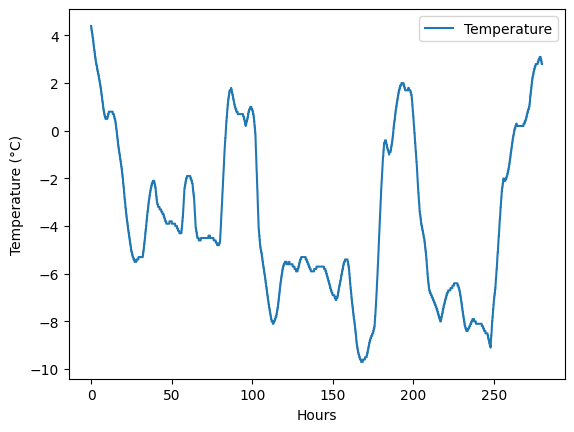

In [29]:
import matplotlib.pyplot as plt

hours_since_beginning_of_year = data.index*5/60

# 7 days * 24 hours per day * 20 5-minute intervals per hour
first_week = 7*24*20

plt.plot(hours_since_beginning_of_year[:first_week],
         data['Temperature'].values[:first_week],
         label='Temperature')
plt.xlabel('Hours')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.show()

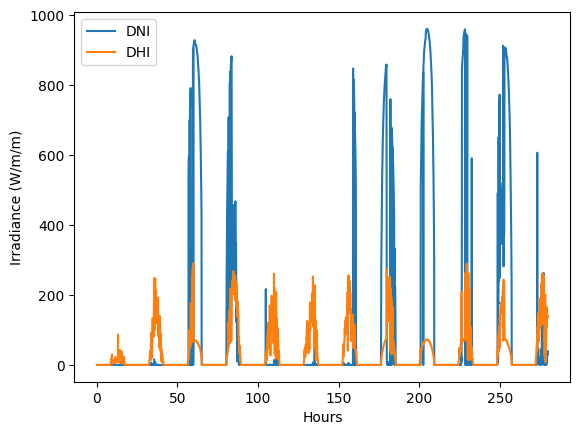

In [30]:
plt.plot(hours_since_beginning_of_year[:first_week],
         data['DNI'].values[:first_week],
         label='DNI')
plt.plot(hours_since_beginning_of_year[:first_week],
         data['DHI'].values[:first_week],
         label='DHI')
plt.xlabel('Hours')
plt.ylabel('Irradiance (W/m/m)')
plt.legend()

plt.show()

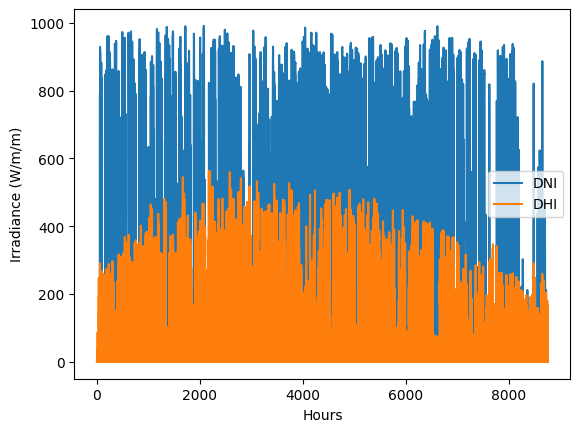

In [31]:
plt.plot(hours_since_beginning_of_year,
         data['DNI'],
         label='DNI')
plt.plot(hours_since_beginning_of_year,
         data['DHI'],
         label='DHI')
plt.xlabel('Hours')
plt.ylabel('Irradiance (W/m/m)')
plt.legend()

plt.show()

## Model Solar Panel Performance

Now that we have the weather data, we can model the solar panel performance.

We will start with this example: https://pvlib-python.readthedocs.io/en/stable/gallery/bifacial/plot_pvfactors_fixed_tilt.html

And possibly use this example to calculate only the monofacial performance: https://pvlib-python.readthedocs.io/en/stable/gallery/bifacial/plot_bifi_model_pvwatts.html

In [32]:
# First we need to install the solar modeling package
!pip install pvlib[optional]

In [33]:
from pvlib import location
from pvlib.bifacial.pvfactors import pvfactors_timeseries

import warnings

# supressing shapely warnings that occur on import of pvfactors
warnings.filterwarnings(action='ignore', module='pvfactors')

In [34]:
times = pd.date_range('2022-01-01', # start at the beginning of the year
                      '2023-01-01', # end at the beginning of the next year
                      freq='5min', # every 5 minutes
                      tz='America/New_York', # select time zone
                      inclusive='left') # only include beginning of year
loc = location.Location(latitude=42.5226, longitude=-82.8809, tz=times.tz) # Lake Shore High School
sp = loc.get_solarposition(times)
# cs = loc.get_clearsky(times) # not needed as we will use weather data instead

# Height of the pv rows, measured at their center (m)
pvrow_height = 1 # default

# Width of the pv rows in the considered 2D plane (m)
pvrow_width = 4 # default

pitch = 10 # default

# Ground coverage ratio of the pv array
gcr = pvrow_width / pitch
# small gcr means less shading, I think (see link below)
# https://pvlib-python.readthedocs.io/en/stable/gallery/shading/plot_passias_diffuse_shading.html

axis_azimuth = 180 #
# albedo = 0.2 # not needed as we will use weather

Text(0, 0.5, 'Irradiance [W m$^{-2}$]')

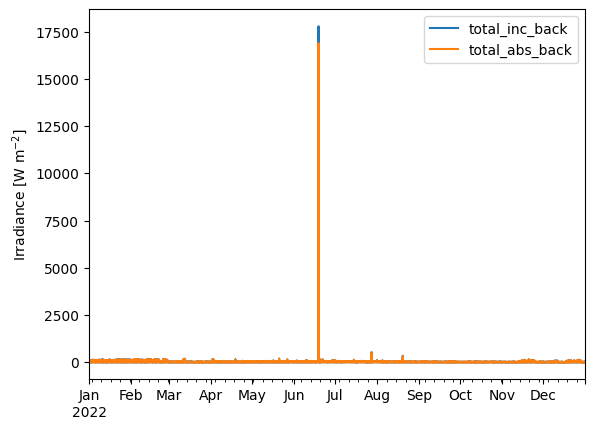

In [35]:
irrad = pvfactors_timeseries(
    solar_azimuth=sp['azimuth'],
    solar_zenith=sp['apparent_zenith'],
    surface_azimuth=180,  # south-facing array
    surface_tilt=12.5, # degrees,
    axis_azimuth=90,  # 90 degrees off from surface_azimuth.  270 is ok too
    timestamps=times,
    dni=data['DNI'],
    dhi=data['DHI'],
    gcr=gcr,
    pvrow_height=pvrow_height,
    pvrow_width=pvrow_width,
    albedo=data['Surface Albedo'],
    n_pvrows=1,
    index_observed_pvrow=0
)

# turn into pandas DataFrame
irrad = pd.concat(irrad, axis=1)

irrad[['total_inc_back', 'total_abs_back']].plot()
plt.ylabel('Irradiance [W m$^{-2}$]')

Something is wrong with the back calculation. Let's look at just the front irradiance. Here is the docstring for the function the produces the `irrad` object:

```
Returns
    -------
    poa_front: numeric
        Calculated incident irradiance on the front surface of the PV modules
        (W/m2)
    poa_back: numeric
        Calculated incident irradiance on the back surface of the PV modules
        (W/m2)
    poa_front_absorbed: numeric
        Calculated absorbed irradiance on the front surface of the PV modules
        (W/m2), after AOI losses
    poa_back_absorbed: numeric
        Calculated absorbed irradiance on the back surface of the PV modules
        (W/m2), after AOI losses
```

https://pvlib-python.readthedocs.io/en/stable/_modules/pvlib/bifacial/pvfactors.html

In [36]:
irrad['total_abs_front'].head()

2022-01-01 00:00:00-05:00    0.0
2022-01-01 00:05:00-05:00    0.0
2022-01-01 00:10:00-05:00    0.0
2022-01-01 00:15:00-05:00    0.0
2022-01-01 00:20:00-05:00    0.0
Freq: 5T, Name: total_abs_front, dtype: float64

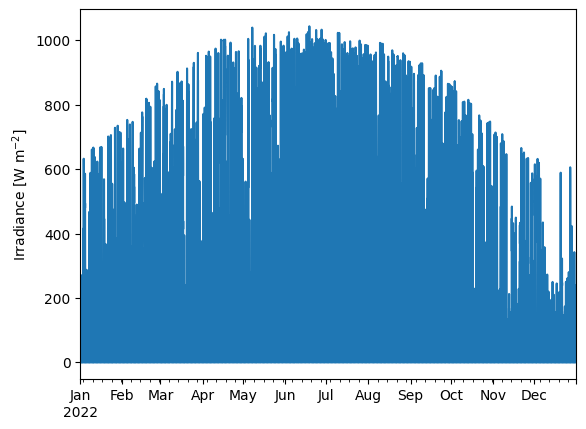

In [37]:
irrad['total_abs_front'].plot()
plt.ylabel('Irradiance [W m$^{-2}$]')
plt.show()

Next steps:
* Calculate energy available every 15 minutes (Wh/m/m). This will allow comparison with the solar telemetry data.

## Analyze Solar Data

In [38]:
data_file_solar = {}
data_file_solar[2023] = '1_bzWjw6HiuSwa5zOrSbsbd5qLE837leX'
data_file_solar[2022] = '1cntIRQ6nIfVqwiJp-CxyYBMfh6SAmrzD'
data_file_solar[2021] = '1tlLJNLU2FMu-ZqqsRygFjIyQhPmxPAzy'
data_file_solar[2020] = '15ub5BE-MbktnFV5MGFh559-nmH1SoUBA'
data_file_solar[2019] = '1Hc49CskJfSKXjMGDZUgE-2302HDjnqwQ'


In [39]:
solar_data = download_data_file(data_file_solar[2022], type='solar')
solar_data.head()

,power
date,
2022-01-01 00:00:00,NaN
2022-01-01 00:15:00,NaN
2022-01-01 00:30:00,NaN
2022-01-01 00:45:00,NaN
2022-01-01 01:00:00,NaN


<Axes: xlabel='date'>

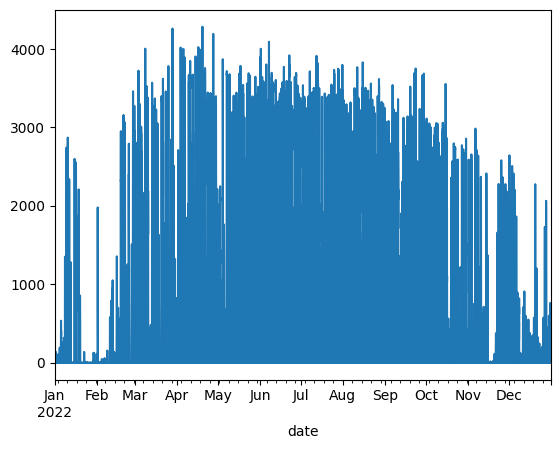

In [40]:
solar_data['power'].plot()

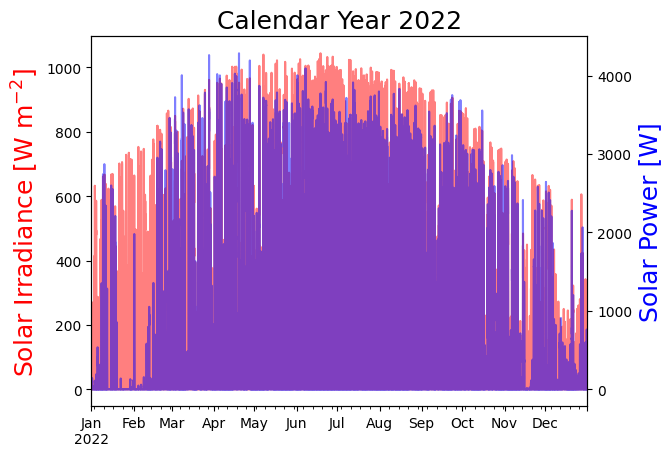

In [41]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
irrad['total_abs_front'].plot(ax=ax1,color='red',alpha=0.5)
solar_data['power'].plot(ax=ax2,color='blue',alpha=0.5)
plt.title('Calendar Year 2022',fontsize=18)
ax1.set_ylabel('Solar Irradiance [W m$^{-2}$]', color='red', fontsize=18)
ax2.set_ylabel('Solar Power [W]', color='blue', fontsize=18)
plt.show()

In [42]:
irrad_resample = irrad['total_abs_front'].resample('15min').mean()
irrad_resample.head()

2022-01-01 00:00:00-05:00    0.0
2022-01-01 00:15:00-05:00    0.0
2022-01-01 00:30:00-05:00    0.0
2022-01-01 00:45:00-05:00    0.0
2022-01-01 01:00:00-05:00    0.0
Freq: 15T, Name: total_abs_front, dtype: float64

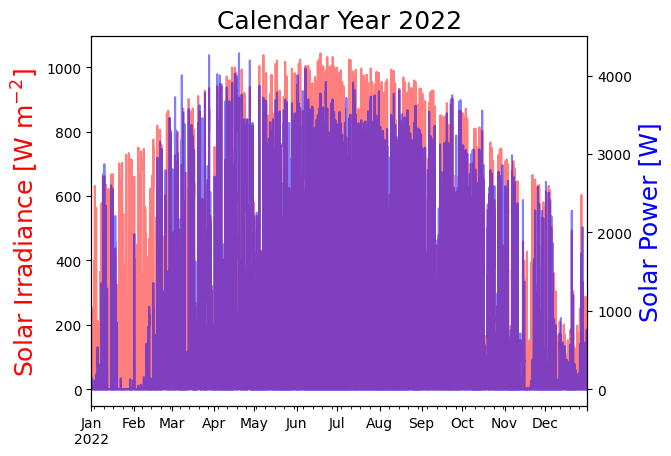

In [43]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
irrad_resample.plot(ax=ax1,color='red',alpha=0.5)
solar_data['power'].plot(ax=ax2,color='blue',alpha=0.5)
plt.title('Calendar Year 2022',fontsize=18)
ax1.set_ylabel('Solar Irradiance [W m$^{-2}$]', color='red', fontsize=18)
ax2.set_ylabel('Solar Power [W]', color='blue', fontsize=18)
plt.show()

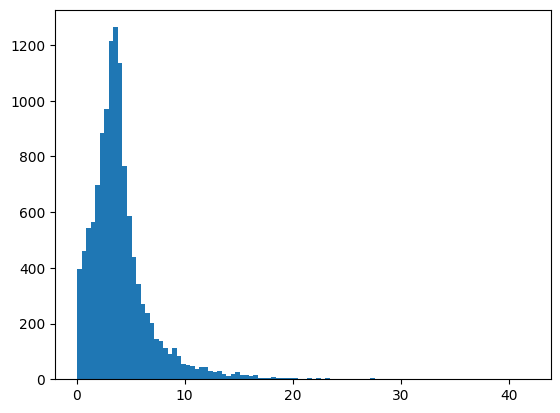

In [44]:
irrandiance = irrad_resample.to_numpy()
solar = solar_data['power'].to_numpy()

min_irrandiance = 50 # W / m / m
min_solar_power = 50 # W

i = irrandiance > min_irrandiance
j = solar > min_solar_power

k = i & j

area = solar[k] / irrandiance[k]

plt.hist(area, bins=100)
plt.show()


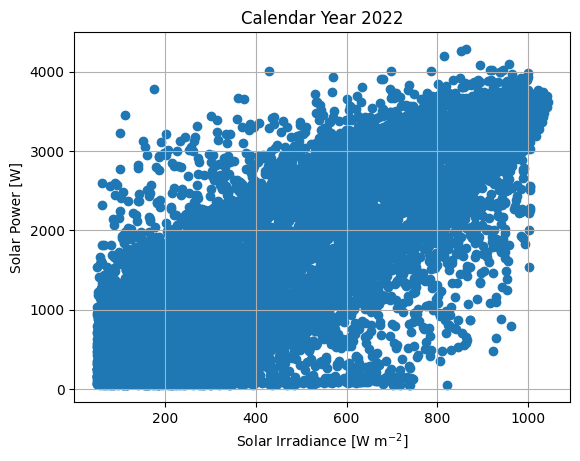

In [45]:
plt.scatter(irrandiance[k], solar[k])
plt.xlabel('Solar Irradiance [W m$^{-2}$]')
plt.ylabel('Solar Power [W]')
plt.title('Calendar Year 2022')
plt.grid(True)
plt.show()

In [46]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(irrandiance[k], solar[k])
print("slope = ",round(slope,3)," 1 / m / m")
print("intercept = ",round(intercept,2)," W")

slope =  2.967  1 / m / m
intercept =  242.65  W


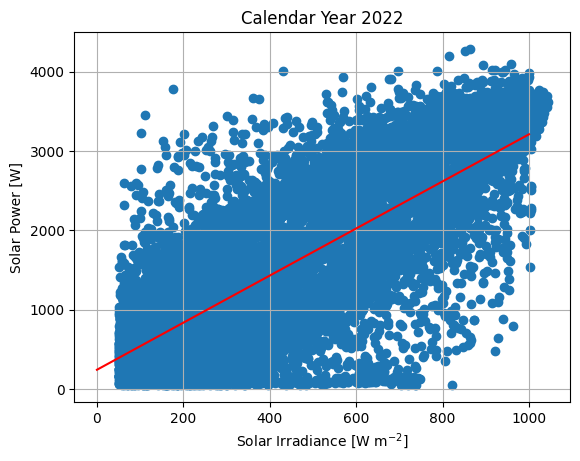

In [47]:
import numpy as np

def myfunc(x):
  return slope * x + intercept

x_plot = np.linspace(0, 1000, 101)
y_plot = myfunc(x_plot)

plt.scatter(irrandiance[k], solar[k])
plt.plot(x_plot, y_plot, color='red')
plt.xlabel('Solar Irradiance [W m$^{-2}$]')
plt.ylabel('Solar Power [W]')
plt.title('Calendar Year 2022')
plt.grid(True)
plt.show()

## Generalize as a Function

In [48]:
def analyze_year(year=2019):

    ## Download meterological data
    met_data = data = download_data_file(data_file_ids[year], type='met')
    print("Finished downloading met data")

    ## Configure solar panel simulation
    times = pd.date_range(str(year)+'-01-01', # start at the beginning of the year
                      str(year+1)+'-01-01', # end at the beginning of the next year
                      freq='5min', # every 5 minutes
                      tz='America/New_York', # select time zone
                      inclusive='left') # only include beginning of year
    loc = location.Location(latitude=42.5226, longitude=-82.8809, tz=times.tz) # Lake Shore High School
    sp = loc.get_solarposition(times)
    # cs = loc.get_clearsky(times) # not needed as we will use weather data instead

    # Height of the pv rows, measured at their center (m)
    pvrow_height = 1 # default

    # Width of the pv rows in the considered 2D plane (m)
    pvrow_width = 4 # default

    pitch = 10 # default

    # Ground coverage ratio of the pv array
    gcr = pvrow_width / pitch
    # small gcr means less shading, I think (see link below)
    # https://pvlib-python.readthedocs.io/en/stable/gallery/shading/plot_passias_diffuse_shading.html

    axis_azimuth = 180 #
    # albedo = 0.2 # not needed as we will use weather

    ## Simulate solar panels
    irrad = pvfactors_timeseries(
        solar_azimuth=sp['azimuth'],
        solar_zenith=sp['apparent_zenith'],
        surface_azimuth=180,  # south-facing array
        surface_tilt=12.5, # degrees,
        axis_azimuth=90,  # 90 degrees off from surface_azimuth.  270 is ok too
        timestamps=times,
        dni=data['DNI'],
        dhi=data['DHI'],
        gcr=gcr,
        pvrow_height=pvrow_height,
        pvrow_width=pvrow_width,
        albedo=data['Surface Albedo'],
        n_pvrows=1,
        index_observed_pvrow=0
    )
    print("Finished simulating solar cells")

    # turn into pandas DataFrame
    irrad = pd.concat(irrad, axis=1)

    # Convert to 15 minute intervals
    irrad_resample = irrad['total_abs_front'].resample('15min').mean()

    ## Download solar data
    solar_data = download_data_file(data_file_solar[year], type='solar')
    print("Finished downloading solar panel data")

    ## Plot data
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    irrad_resample.plot(ax=ax1,color='red',alpha=0.5)
    solar_data['power'].plot(ax=ax2,color='blue',alpha=0.5)
    plt.title('Calendar Year '+str(year),fontsize=18)
    ax1.set_ylabel('Solar Irradiance [W m$^{-2}$]', color='red', fontsize=18)
    ax2.set_ylabel('Solar Power [W]', color='blue', fontsize=18)
    plt.show()

    ## Perform regression
    irrandiance = irrad_resample.to_numpy()
    solar = solar_data['power'].to_numpy()
    i = irrandiance > min_irrandiance
    j = solar > min_solar_power

    k = i & j

    slope, intercept, r_value, p_value, std_err = linregress(irrandiance[k], solar[k])

    ## Plot data

    def myfunc(x):
        return slope * x + intercept

    x_plot = np.linspace(0, 1000, 101)
    y_plot = myfunc(x_plot)

    plt.scatter(irrandiance[k], solar[k])
    plt.plot(x_plot, y_plot, color='red')
    plt.xlabel('Solar Irradiance [W m$^{-2}$]',fontsize=18)
    plt.ylabel('Solar Power [W]',fontsize=18)
    plt.title('Calendar Year '+str(year),fontsize=18)
    plt.grid(True)
    plt.show()
    print("slope = ",round(slope,3)," 1 / m / m")
    print("intercept = ",round(intercept,2)," W")
    print("r_value = ",round(r_value,3))
    print("p_value = ",round(p_value,3))
    print("std_err = ",round(std_err,3))



## Calendar Year 2019

Finished downloading met data
Finished simulating solar cells
Finished downloading solar panel data


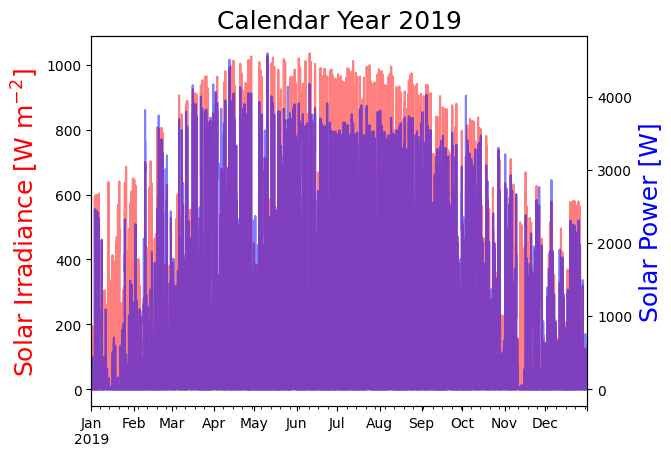

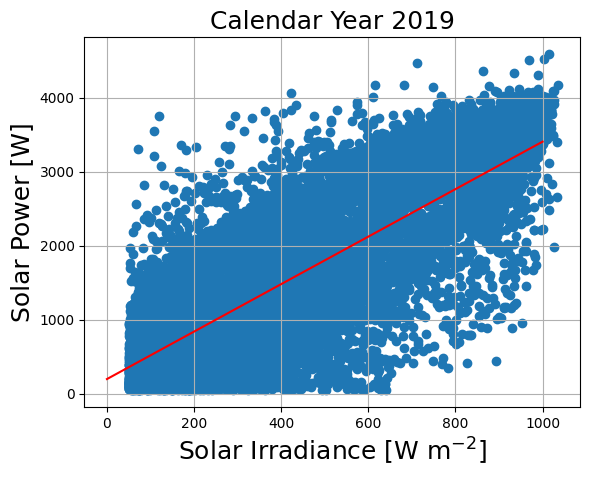

slope =  3.209  1 / m / m
intercept =  196.81  W
r_value =  0.797
p_value =  0.0
std_err =  0.021


In [49]:
analyze_year(2019)

## Calendar Year 2020



Finished downloading met data
Finished simulating solar cells
Finished downloading solar panel data


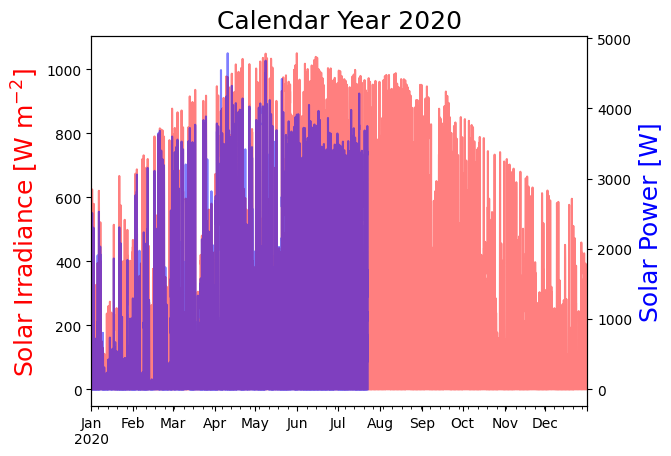

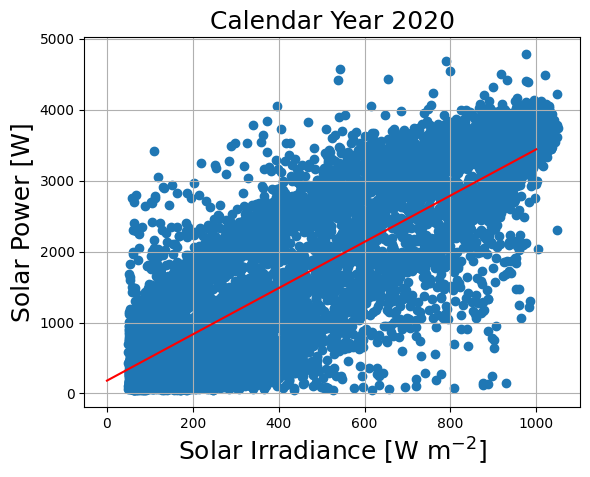

slope =  3.26  1 / m / m
intercept =  181.02  W
r_value =  0.811
p_value =  0.0
std_err =  0.027


In [50]:
analyze_year(2020)

## Calendar Year 2021

Finished downloading met data
Finished simulating solar cells
Finished downloading solar panel data


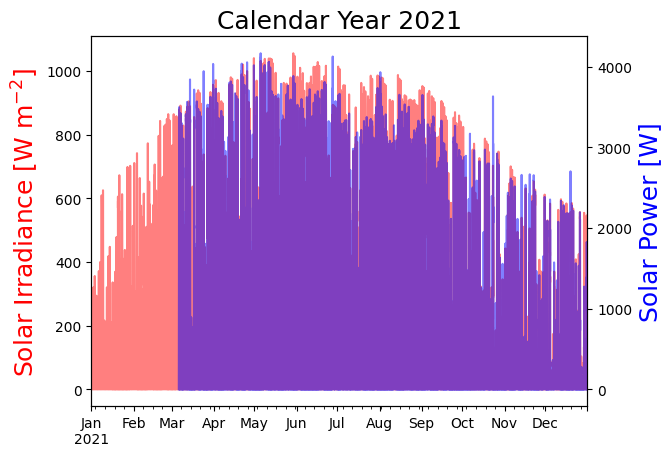

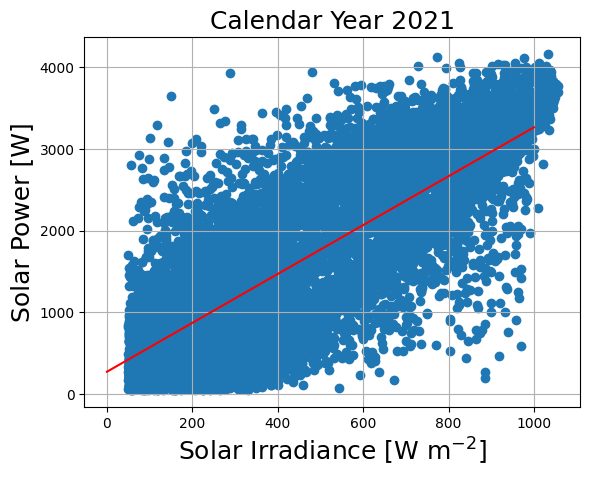

slope =  2.994  1 / m / m
intercept =  272.94  W
r_value =  0.794
p_value =  0.0
std_err =  0.021


In [51]:
analyze_year(2021)

## Calendar Year 2022

Finished downloading met data
Finished simulating solar cells
Finished downloading solar panel data


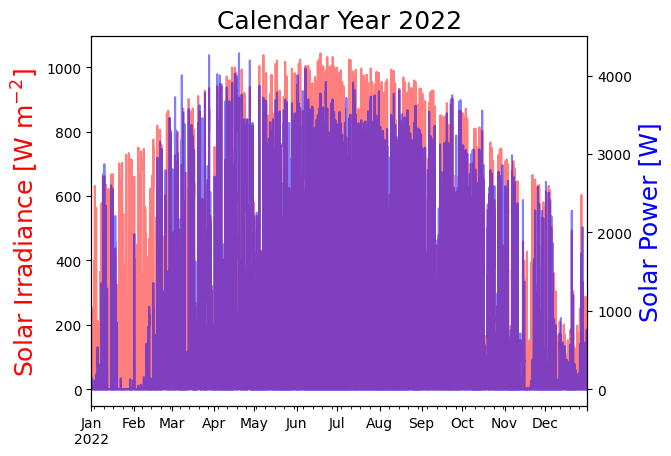

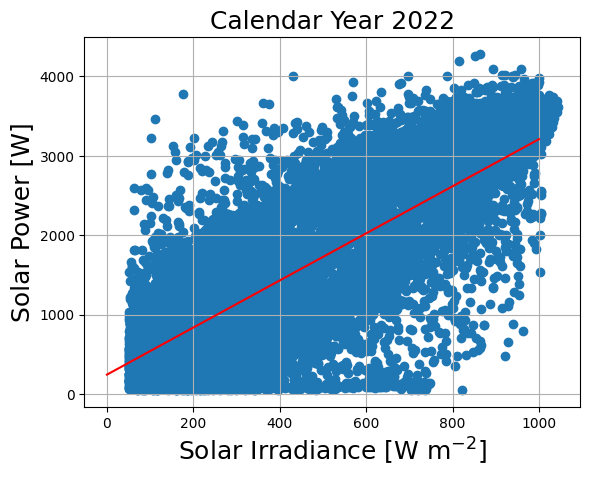

slope =  2.967  1 / m / m
intercept =  242.65  W
r_value =  0.776
p_value =  0.0
std_err =  0.022


In [52]:
analyze_year(2022)